In [2]:
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import umap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import datetime as dt
from sklearn.manifold import TSNE
import seaborn as sns



In [3]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data
X = covertype.data.features
y = covertype.data.targets

In [4]:
print(X.shape)
print(y.shape)

print(y.Cover_Type.value_counts())

(581012, 54)
(581012, 1)
Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


In [5]:
# Réduire la taille de la base de donnée
data_size = 1

if data_size < 1:
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=data_size, stratify=y, random_state=42)
else: #si on prend tout le dataset, pas besoin de split
    X_sample = X
    y_sample = y
print(X_sample.shape)

(581012, 54)


In [6]:
### Standardiser données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

In [7]:
# Over-sampling avec SMOTE
k_neighbors_smote=5
sm = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
X_oversampled, y_oversampled = sm.fit_resample(X_scaled, y_sample)

In [8]:
print("After over-sampling: ")
print(y_oversampled.Cover_Type.value_counts())

After over-sampling: 
Cover_Type
5    283301
2    283301
1    283301
7    283301
3    283301
6    283301
4    283301
Name: count, dtype: int64


In [11]:
n_neighbors = 5
min_dist = 0.1
n_components = 2 # 2 pour 2D, 3 pour 3D

reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
embedding = reducer.fit_transform(X_scaled)
embedding.shape

C:\Users\helen\source\repos_git\TP2-Apprentissage_automatique\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(581012, 2)

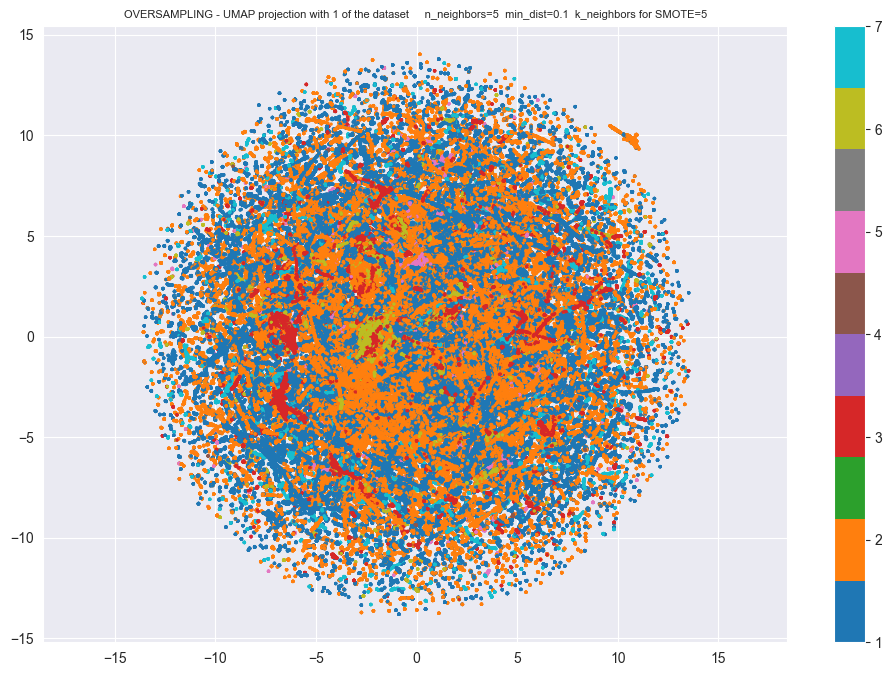

In [12]:
if n_components == 3: # Affichage en 3D
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y_sample.Cover_Type, s=1)
    # Ajout de la colorbar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=10)
    cbar.set_label("Cover Type", fontsize=8)
    
elif n_components == 2: # Affichage en 2D
    plt.figure(figsize=(12,8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y_sample.Cover_Type, cmap='tab10', s=2)
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar()
    #plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
    date = dt.datetime.now().time()
    date = (str(date))
    date = date.replace(":", "-")
    plt.title('OVERSAMPLING - UMAP projection with ' + str(data_size) +" of the dataset   " + "  n_neighbors="+ str(n_neighbors) + "  min_dist="+ str(min_dist) + "  k_neighbors for SMOTE="+str(k_neighbors_smote), fontsize=8)
    plt.savefig('../images/UMAP-SMOTE---'+ date +'.png')

In [ ]:
#Classificatiom
# Diviser les données oversamplées en ensemble d'entraînement et de test
y_oversampled = y_oversampled.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X_oversampled, y_oversampled.ravel(),  
    test_size=0.3, random_state=42, stratify=y_oversampled
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


In [ ]:
# Appliquer t-SNE sur les données suréchantillonnées
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_oversampled)

# Tracer les points
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_oversampled,
    palette="tab10",
    legend="full",
    alpha=0.7
)
plt.title("Visualisation des classes avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Classes", loc="best")
plt.grid(True)
plt.show()

/Users/carchaf/PycharmProjects/TP2-Apprentissage_automatique/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
